In [18]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')

device: cuda:0


In [20]:
class NN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction = 'mean')
        self.layers = layers


        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])


        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)

            nn.init.zeros_(self.linears[i].bias.data)

        


    def forward(self,x,t):
        a = torch.cat([x,t], dim = 1)

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)

        b = self.linears[-1](a)

        return b



In [21]:
layers = np.array([2,128,128,128,128,1])

net_phi = NN(layers).to(device)
net_mu = NN(layers).to(device)

In [24]:
# Define LHS

def lhs(n:int, d:int, low: np.ndarray, high: np.ndarray) -> np.ndarray:

    low = np.asarray(low).reshape(1,d)
    high = np.asarray(high).reshape(1,d)

    m = np.random.rand(n,d)

    a = np.linspace(0,1,n, endpoint = False).reshape(n,1)
    b = np.linspace(1/n,1,n).reshape(n,1)

    pts =  a + m*(b-a)

    for j in range(d):
        np.random.shuffle(pts[:,j])

    return low+(high-low)*pts


In [27]:
# Create Collocation Points

X = lhs(n = 10000, d=2, low=np.array([-1,0]), high = np.array([1,1]))

x_f = (X[:,[0]])


x_f = torch.tensor(x_f, dtype = torch.float32, device = device, requires_grad=True)


t_f = (X[:,[1]])

t_f = torch.tensor(t_f, dtype = torch.float32, device = device, requires_grad=True)



In [28]:
def bc_loss():
    x_l = -torch.ones(200,1)
    x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)


    x_r = torch.ones(200,1)
    x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)


    t = torch.rand(200,1)
    t = torch.tensor(t, dtype = torch.float32, device = device)


    phi_left = net_phi(x_l,t)
    phi_right = net_phi(x_r, t)

    phi_l_x = torch.autograd.grad(phi_left, x_l, torch.ones_like(phi_left), create_graph=True)[0]
    phi_r_x = torch.autograd.grad(phi_right, x_r, torch.ones_like(phi_right), create_graph=True)[0]

    res_bc_1 = phi_left - phi_right
    loss_bc_1 = torch.mean(res_bc_1 ** 2)

    res_bc_2 = phi_l_x - phi_r_x
    loss_bc_2 = torch.mean(res_bc_2 ** 2)


    loss_bc = loss_bc_1 + loss_bc_2


    return loss_bc

In [29]:
def ic_loss():
    x = torch.linspace(-1,1,200).view(-1,1)
    x = torch.tensor(x, dtype = torch.float32, device = device)


    t = torch.zeros(200,1)
    t = torch.tensor(t, dtype = torch.float32, device = device)


    phi = net_phi(x,t)

    res_ic = phi + torch.cos(2*np.pi*x)

    loss_ic = torch.mean(res_ic**2)

    return loss_ic

In [30]:
def pde_loss(x,t):
    gamma_1 = 1e-6
    gamma_2 = 0.01
    
    
    
    
    phi = net_phi(x,t)

    phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
    phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
    phi_x_x = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]


    mu = net_mu(x,t)
    mu_x = torch.autograd.grad(mu, x, torch.ones_like(mu), create_graph=True)[0]
    mu_x_x = torch.autograd.grad(mu_x, x, torch.ones_like(mu_x), create_graph=True)[0]


    res_mu = mu - (gamma_2*(phi**3 - phi) - gamma_1*phi_x_x)
    loss_mu = torch.mean(res_mu**2)


    res_pde = phi_t - mu_x_x
    pde_loss = torch.mean(res_pde**2)


    loss_pde = loss_mu + pde_loss


    return loss_pde

    

In [31]:
def add_losses():
    loss_bc = bc_loss()
    loss_ic = ic_loss()
    loss_pde = pde_loss(x_f, t_f)


    total_loss = loss_bc + loss_ic + loss_pde


    return total_loss
    

In [34]:
optimizer_phi = torch.optim.Adam(net_phi.parameters(), lr = 0.001)
optimizer_mu = torch.optim.Adam(net_mu.parameters(), lr = 0.001)

In [35]:
torch.manual_seed(42)

In [36]:
start_time = time.time()

num_epochs = 20000

total_loss_list = []

for epoch in range(num_epochs):
    optimizer_phi.zero_grad()
    optimizer_mu.zero_grad()
    

    total_loss = add_losses()

    total_loss.backward()
    

    optimizer_phi.step()
    optimizer_mu.step()
    

    
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}:  total loss={total_loss.item():.3e}")

    
end_time = time.time()

print(f'Total Training Time: {(end_time - start_time): .4f}seconds')

/tmp/ipykernel_900803/1306876392.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype = torch.float32, device = device)


Epoch 0:  total loss=6.458e-01
Epoch 500:  total loss=5.016e-01
Epoch 1000:  total loss=4.990e-01
Epoch 1500:  total loss=7.510e-03
Epoch 2000:  total loss=2.170e-03
Epoch 2500:  total loss=3.541e-03
Epoch 3000:  total loss=1.091e-03
Epoch 3500:  total loss=1.050e-03
Epoch 4000:  total loss=6.551e-03
Epoch 4500:  total loss=1.495e-03
Epoch 5000:  total loss=9.912e-04
Epoch 5500:  total loss=3.060e-03
Epoch 6000:  total loss=1.695e-03
Epoch 6500:  total loss=1.240e-03
Epoch 7000:  total loss=1.309e-03
Epoch 7500:  total loss=4.161e-03
Epoch 8000:  total loss=5.995e-04
Epoch 8500:  total loss=8.943e-04
Epoch 9000:  total loss=3.182e-04
Epoch 9500:  total loss=4.141e-04
Epoch 10000:  total loss=2.241e-04
Epoch 10500:  total loss=9.077e-04
Epoch 11000:  total loss=8.460e-04
Epoch 11500:  total loss=4.414e-04
Epoch 12000:  total loss=2.148e-04
Epoch 12500:  total loss=1.937e-04
Epoch 13000:  total loss=4.792e-04
Epoch 13500:  total loss=1.881e-04
Epoch 14000:  total loss=1.951e-04
Epoch 145

In [ ]:
# # Fine-tuning with LBFGS

# lbfgs_history_phi = []

# lbfgs_phi = torch.optim.LBFGS(
#     net_phi.parameters(),
#     lr=1.0,
#     max_iter=50000,          # large cap; will stop early via tolerances
#     max_eval=50000,
#     history_size=100,
#     line_search_fn="strong_wolfe",
#     tolerance_grad=1e-9,
#     tolerance_change=1e-9,
# )


# lbfgs_phi_iter = 0

# def closure():
#     global lbfgs_phi_iter
#     lbfgs_phi.zero_grad()

#     total_loss = add_losses()   # must return a scalar tensor
#     total_loss.backward()

#     lbfgs_history_phi.append(total_loss.item())

#     lbfgs_phi_iter += 1


#     if lbfgs_phi_iter % 50 == 0:
#         print(f"[LBFGS iter {lbfgs_phi_iter}] loss = {total_loss.item():.6e}")

#     return total_loss


# net_phi.train()
# lbfgs_phi.step(closure)

# print("LBFGS done. Total closure calls:", lbfgs_phi_iter)

LBFGS done. Total closure calls: 3


/tmp/ipykernel_900803/1306876392.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype = torch.float32, device = device)


In [ ]:
# # Fine-tuning with LBFGS

# lbfgs_history_mu = []

# lbfgs_mu = torch.optim.LBFGS(
#     net_mu.parameters(),
#     lr=1.0,
#     max_iter=50000,          # large cap; will stop early via tolerances
#     max_eval=50000,
#     history_size=100,
#     line_search_fn="strong_wolfe",
#     tolerance_grad=1e-9,
#     tolerance_change=1e-9,
# )


# lbfgs_mu_iter = 0

# def closure():
#     global lbfgs_mu_iter
#     lbfgs_mu.zero_grad()

#     total_loss = add_losses()   # must return a scalar tensor
#     total_loss.backward()

#     lbfgs_history_mu.append(total_loss.item())

#     lbfgs_mu_iter += 1


#     if lbfgs_mu_iter % 50 == 0:
#         print(f"[LBFGS iter {lbfgs_mu_iter}] loss = {total_loss.item():.6e}")

#     return total_loss


# net_mu.train()
# lbfgs_mu.step(closure)

# print("LBFGS done. Total closure calls:", lbfgs_mu_iter)

LBFGS done. Total closure calls: 3


/tmp/ipykernel_900803/1306876392.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype = torch.float32, device = device)


In [37]:
params = list(net_phi.parameters()) + list(net_mu.parameters())


optimizer_lbfgs = torch.optim.LBFGS(
    params,
    lr=1.0,                  # common starting point
    max_iter=5000,           # total iterations inside .step()
    max_eval=5000,
    history_size=100,
    line_search_fn="strong_wolfe"
)


lbfgs_iter = 0

def closure():
    global lbfgs_iter

    optimizer_lbfgs.zero_grad(set_to_none=True)

    loss = add_losses()

    loss.backward()

    if lbfgs_iter % 50 == 0:
        print(f"[LBFGS iter {lbfgs_iter}] loss = {loss.item():.3e}")
    lbfgs_iter += 1

    return loss


print("Starting LBFGS fine-tuning...")
optimizer_lbfgs.step(closure)
print("LBFGS done.")

Starting LBFGS fine-tuning...
[LBFGS iter 0] loss = 9.943e-04


/tmp/ipykernel_900803/1306876392.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_900803/1306876392.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype = torch.float32, device = device)


[LBFGS iter 50] loss = 2.080e-04
LBFGS done.


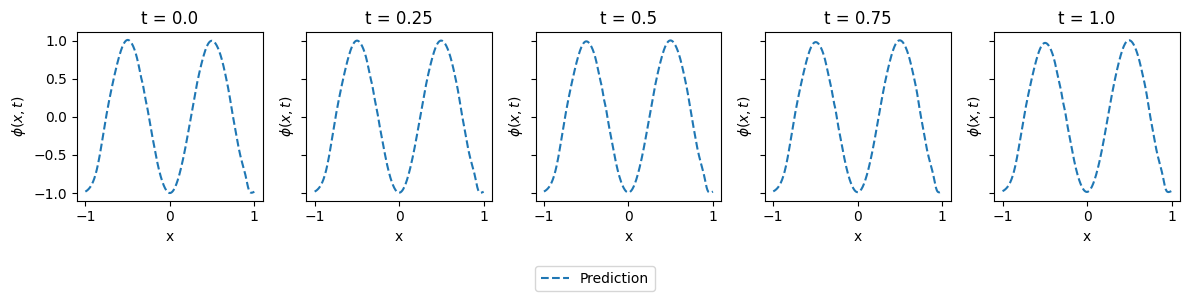

In [39]:
t_list = [0.0, 0.25, 0.50, 0.75, 1.0]

x = np.linspace(-1,1,400).reshape(-1,1)

x_t = torch.tensor(x, device = device, dtype = torch.float32)

fig, axes = plt.subplots(1,5, sharey = True, figsize=(12, 3))


for i, tval in enumerate(t_list):
    ax = axes[i]

    t = np.full_like(x, tval)
    t_t = torch.tensor(t, device = device, dtype = torch.float32)

    net_phi.eval()

    with torch.no_grad():
        phi_pred = net_phi(x_t, t_t).detach().cpu().numpy().reshape(-1)



    ax.plot(x.reshape(-1), phi_pred, '--', label = 'Prediction')

    ax.set_title(f't = {tval}')
    ax.set_xlabel('x')


    ax.set_ylabel(r'$\phi(x,t)$')




handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=True)
fig.tight_layout(rect=[0, 0.12, 1, 1])
plt.show()